## Submission by

| Name       | Roll No.|
| ---------  |---------|
| Ankan Kar  | MCS202303   |
| Aman       | MCS202305    |
| Utpalraj Kemprai      |  MDS202352   |

## Importing the libraries

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

## Downloading the dataset

In [2]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset
!unzip sms-spam-collection-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
sms-spam-collection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sms-spam-collection-dataset.zip
replace spam.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Data loading and preprocessing

In [3]:
data = pd.read_csv('/content/spam.csv', encoding='latin-1', index_col=False)
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Dropping unnecessary columns


In [4]:
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
data.columns = ['label', 'sms']
data['label'] = data['label'].map({'ham': 0, 'spam': 1})
data.head()

,label,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Checking for missing values

In [5]:
data.isna().mean()

,0
label,0.0
sms,0.0


Checking for data imbalance

In [6]:
data.value_counts('label')

,count
label,
0,4825
1,747


Preprocessing the text

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

In [9]:
data['processed_sms'] = data['sms'].apply(preprocess_text)
data.head()

,label,sms,processed_sms
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


Splitting into train and test data

In [10]:
X_train,X_test,y_train,y_test = train_test_split(
            data["processed_sms"],data["label"], test_size = 0.25, random_state = 14)

In [11]:
# Combine X_train and y_train into a DataFrame
train_data = pd.DataFrame({'processed_sms': X_train, 'label': y_train})

In [12]:
# combine X_test and y_test into a DataFrame
test_data = pd.DataFrame({'processed_sms': X_test, 'label': y_test})

Encoding the processed sms and storing the vocabulary for the training data

In [13]:
# Create vocabulary for training data
vocab = defaultdict(lambda: len(vocab))  # Assigns each new word an increasing index

def encode_text(text):
    return [vocab[word] for word in text.split()]

In [14]:
train_data['encoded_sms'] = train_data['processed_sms'].apply(encode_text)
train_data.head()

,processed_sms,label,encoded_sms
4564,honeybee said im sweetest world god laughed am...,0,"[0, 1, 2, 3, 4, 5, 6, 7, 1, 8, 9, 10, 11, 12, ..."
4263,broke list reason nobody town cant tell shes s...,0,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28]"
2544,sister belongs 2 family hope tomorrow pray 4 h...,0,"[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 36, 3..."
1068,someone u know asked dating service 2 contact ...,1,"[60, 61, 62, 63, 64, 65, 31, 66, 24, 67, 68, 6..."
446,well done blimey exercise yeah kinda remember ...,0,"[75, 76, 77, 78, 79, 80, 81, 82, 83]"


In [15]:
vocab_size = len(vocab)
vocab_size

7605

In [16]:
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

Encoding test data using the vocabulary of train data

In [17]:
def encode_test_data(text):
  # index vocab_size for out of vocabulary word
    return [word_to_idx[word] if word in word_to_idx else vocab_size for word in text.split()]

In [18]:
# encoding the test data
test_data['encoded_sms'] = test_data['processed_sms'].apply(encode_test_data)
test_data.head()

,processed_sms,label,encoded_sms
4596,full heat pa applyed oil pa,0,"[915, 7605, 399, 7605, 7380, 399]"
990,26th july,0,"[5339, 5340]"
4618,sorry ill call later meeting,0,"[201, 138, 68, 763, 762]"
35,yup ok go home look timing msg ì xuhui going l...,0,"[345, 334, 289, 241, 659, 805, 13, 236, 3636, ..."
2455,abeg make profit start using get sponsor next ...,0,"[7605, 572, 2813, 2212, 1279, 123, 7605, 364, ..."


In [19]:
X_test = test_data['encoded_sms']
y_test = test_data['label']

Oversampling from the minority class in the training data to handle data imbalance

In [20]:
# Separate majority and minority classes
majority_class = train_data[train_data['label'] == 0]
minority_class = train_data[train_data['label'] == 1]

# Upsample minority class
minority_upsampled = resample(minority_class,
                              replace=True,  # Sample with replacement
                              n_samples=len(majority_class),  # Match majority class size
                              random_state=14)  # Consistent results

# Combine majority class with upsampled minority class
upsampled_train_data = pd.concat([majority_class, minority_upsampled])

In [21]:
# Separate features and labels from the balanced DataFrame
X_train_balanced = upsampled_train_data['encoded_sms']
y_train_balanced = upsampled_train_data['label']

## Defining the model

In [22]:
# Hyperparameters
num_embeddings = vocab_size + 2 # +2 for padding and out of vocabulary words
embedding_dim = 128
epochs = 100
hidden_dim = 64
num_layers = 2
bidirectional = True
dropout = 0.2
learning_rate = 0.001
output_dim = 1
criterion = nn.BCELoss()

In [23]:
class myRNN(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, num_layers, output_dim, dropout, bidirectional):
        super(myRNN, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        hidden = hidden[-1]  # take the last hidden state
        out = self.fc(hidden)
        return nn.Sigmoid()(out)

In [24]:
class myLSTM(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, num_layers, output_dim, dropout, bidirectional):
        super(myLSTM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = hidden[-1]  # take the last hidden state
        out = self.fc(hidden)
        return nn.Sigmoid()(out)

### Checking number of parameters in the two models

In [25]:
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [27]:
rnn_model = myRNN(num_embeddings, embedding_dim, hidden_dim, num_layers, output_dim, dropout, bidirectional).to(device)
rnn_optimizer = Adam(rnn_model.parameters(), lr=0.001)
print("Number of parameters in RNN Model: ",get_n_params(rnn_model))

Number of parameters in RNN Model:  1023425


In [28]:
lstm_model = myLSTM(num_embeddings, embedding_dim, hidden_dim, num_layers, output_dim, dropout, bidirectional).to(device)
lstm_optimizer = Adam(lstm_model.parameters(), lr=0.001)
print("Number of parameters in LSTM Model: ",get_n_params(lstm_model))

Number of parameters in LSTM Model:  1172417


## Training and evaluating the models

In [29]:
# Padding function
def pad_sequences(sequences, padding_value=vocab_size+1):
    max_len = max(len(seq) for seq in sequences)
    padded_sequences = [seq + [padding_value] * (max_len - len(seq)) for seq in sequences]
    return torch.tensor(padded_sequences, dtype=torch.long)

# Function to prepare batches for training and testing
def batch_tensorize(encoded_texts, labels):
    padded_texts = pad_sequences(encoded_texts)
    label_tensor = torch.tensor(labels.values, dtype=torch.float).view(-1, 1)
    return padded_texts.to(device), label_tensor.to(device)

In [30]:
# Training loop
def train_model(model, optimizer, X_train, y_train, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        X_train_tensor, y_train_tensor = batch_tensorize(X_train, y_train)

        optimizer.zero_grad()
        predictions = model(X_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

In [31]:
# Evaluation function
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test_tensor, y_test_tensor = batch_tensorize(X_test, y_test)
        predictions = model(X_test_tensor)
        predicted_classes = (predictions > 0.5).int()

        predicted_classes = predicted_classes.cpu().numpy()
        y_test_tensor = y_test_tensor.cpu().numpy()

        accuracy = accuracy_score(y_test_tensor, predicted_classes)
        f1 = f1_score(y_test_tensor, predicted_classes)
        precision = precision_score(y_test_tensor, predicted_classes)
        recall = recall_score(y_test_tensor, predicted_classes)
        return accuracy, f1, precision, recall

### Training and evaluating RNN

In [32]:
print("Training RNN model:")
train_model(rnn_model, rnn_optimizer, X_train_balanced, y_train_balanced, num_epochs = epochs)

Training RNN model:
Epoch 1/100, Loss: 0.700220
Epoch 2/100, Loss: 0.681036
Epoch 3/100, Loss: 0.663769
Epoch 4/100, Loss: 0.646755
Epoch 5/100, Loss: 0.629276
Epoch 6/100, Loss: 0.611941
Epoch 7/100, Loss: 0.592894
Epoch 8/100, Loss: 0.574317
Epoch 9/100, Loss: 0.555854
Epoch 10/100, Loss: 0.533511
Epoch 11/100, Loss: 0.511238
Epoch 12/100, Loss: 0.486064
Epoch 13/100, Loss: 0.461479
Epoch 14/100, Loss: 0.433276
Epoch 15/100, Loss: 0.405004
Epoch 16/100, Loss: 0.374380
Epoch 17/100, Loss: 0.343476
Epoch 18/100, Loss: 0.315507
Epoch 19/100, Loss: 0.288555
Epoch 20/100, Loss: 0.266767
Epoch 21/100, Loss: 0.247927
Epoch 22/100, Loss: 0.233485
Epoch 23/100, Loss: 0.219528
Epoch 24/100, Loss: 0.208670
Epoch 25/100, Loss: 0.196963
Epoch 26/100, Loss: 0.183915
Epoch 27/100, Loss: 0.172657
Epoch 28/100, Loss: 0.159778
Epoch 29/100, Loss: 0.148219
Epoch 30/100, Loss: 0.139216
Epoch 31/100, Loss: 0.130985
Epoch 32/100, Loss: 0.122572
Epoch 33/100, Loss: 0.114813
Epoch 34/100, Loss: 0.109905
Epo

In [33]:
# Evaluate the model
print("Evaluating RNN model:")
rnn_accuracy, rnn_f1, rnn_precision, rnn_recall = evaluate_model(rnn_model, X_test, y_test)
print(f"RNN Accuracy: {rnn_accuracy:.4f}")
print(f"RNN F1 Score: {rnn_f1:.4f}")
print(f"RNN Precision: {rnn_precision:.4f}")
print(f"RNN Recall: {rnn_recall:.4f}")

Evaluating RNN model:
RNN Accuracy: 0.8780
RNN F1 Score: 0.6614
RNN Precision: 0.5076
RNN Recall: 0.9486


### Training and evaluating LSTM

In [34]:
print("Training LSTM model:")
train_model(lstm_model, lstm_optimizer, X_train_balanced, y_train_balanced, num_epochs = epochs)

Training LSTM model:
Epoch 1/100, Loss: 0.696758
Epoch 2/100, Loss: 0.687562
Epoch 3/100, Loss: 0.678329
Epoch 4/100, Loss: 0.668595
Epoch 5/100, Loss: 0.657682
Epoch 6/100, Loss: 0.645470
Epoch 7/100, Loss: 0.631252
Epoch 8/100, Loss: 0.615330
Epoch 9/100, Loss: 0.597559
Epoch 10/100, Loss: 0.578085
Epoch 11/100, Loss: 0.557613
Epoch 12/100, Loss: 0.536714
Epoch 13/100, Loss: 0.516648
Epoch 14/100, Loss: 0.498260
Epoch 15/100, Loss: 0.482100
Epoch 16/100, Loss: 0.467988
Epoch 17/100, Loss: 0.454294
Epoch 18/100, Loss: 0.439878
Epoch 19/100, Loss: 0.423797
Epoch 20/100, Loss: 0.407025
Epoch 21/100, Loss: 0.390834
Epoch 22/100, Loss: 0.374949
Epoch 23/100, Loss: 0.361314
Epoch 24/100, Loss: 0.347558
Epoch 25/100, Loss: 0.334490
Epoch 26/100, Loss: 0.321187
Epoch 27/100, Loss: 0.307348
Epoch 28/100, Loss: 0.292684
Epoch 29/100, Loss: 0.276409
Epoch 30/100, Loss: 0.259655
Epoch 31/100, Loss: 0.243472
Epoch 32/100, Loss: 0.228000
Epoch 33/100, Loss: 0.214248
Epoch 34/100, Loss: 0.200669
Ep

In [35]:
print("Evaluating LSTM model:")
lstm_accuracy, lstm_f1, lstm_precision, lstm_recall = evaluate_model(lstm_model, X_test, y_test)
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")
print(f"LSTM F1 Score: {lstm_f1:.4f}")
print(f"LSTM Precision: {lstm_precision:.4f}")
print(f"LSTM Recall: {lstm_recall:.4f}")

Evaluating LSTM model:
LSTM Accuracy: 0.9397
LSTM F1 Score: 0.7961
LSTM Precision: 0.6920
LSTM Recall: 0.9371


### Plotting confusion matrices

In [36]:
# Evaluate both models and get predicted classes
def evaluate_and_get_predictions(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test_tensor, y_test_tensor = batch_tensorize(X_test, y_test)
        predictions = model(X_test_tensor)
        predicted_classes = (predictions > 0.5).int()
        return y_test_tensor.cpu().numpy(), predicted_classes.cpu().numpy()


### RNN confusion matrix

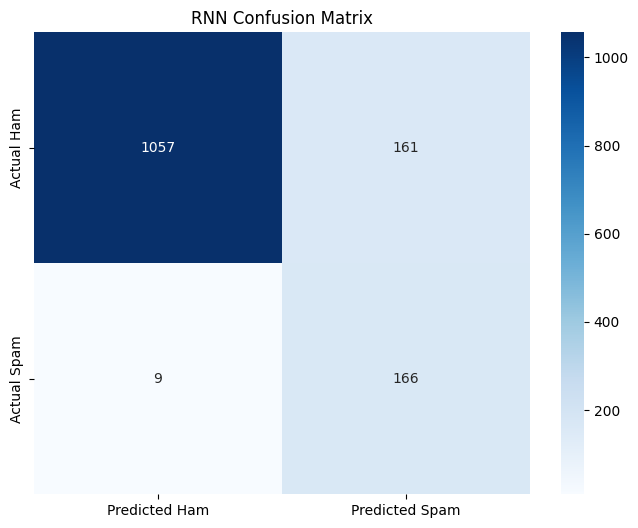

In [37]:
# RNN confusion matrix
y_true_rnn, y_pred_rnn = evaluate_and_get_predictions(rnn_model, X_test, y_test)
cm_rnn = confusion_matrix(y_true_rnn, y_pred_rnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rnn, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Ham', 'Predicted Spam'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.title("RNN Confusion Matrix")
plt.show()

### LSTM confusion matrix

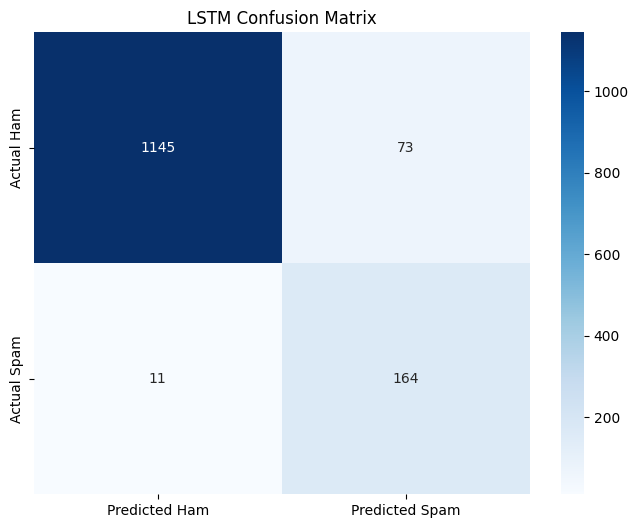

In [38]:
# LSTM confusion matrix
y_true_lstm, y_pred_lstm = evaluate_and_get_predictions(lstm_model, X_test, y_test)
cm_lstm = confusion_matrix(y_true_lstm, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Ham', 'Predicted Spam'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.title("LSTM Confusion Matrix")
plt.show()